# Explainable AI: COMPAS Predictions

Importing libraries

In [189]:
import pandas as pd

# for imputing modes and medians
from sklearn.impute import SimpleImputer

# for random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import shap

# ! Assign target !

In [190]:
target = 'is_recid'

Importing data

In [191]:
# change file name for data if using different version
dfOriginal = pd.read_csv("cox-violent-parsed_filt.csv")

Remove duplicates, only one row per name

In [192]:
dfProcessed = dfOriginal.drop_duplicates(subset=['name'])
dfProcessed.count()

id                          6560
name                       10855
first                      10855
last                       10855
sex                        10855
dob                        10855
age                        10855
age_cat                    10855
race                       10855
juv_fel_count              10855
decile_score               10855
juv_misd_count             10855
juv_other_count            10855
priors_count               10855
days_b_screening_arrest     9781
c_jail_in                   9781
c_jail_out                  9781
c_days_from_compas         10185
c_charge_degree            10185
c_charge_desc              10178
is_recid                   10855
r_charge_degree             3425
r_days_from_arrest          2281
r_offense_date              3425
r_charge_desc               3368
r_jail_in                   2281
violent_recid                  0
is_violent_recid           10855
vr_charge_degree             809
vr_offense_date              809
vr_charge_

Remove unused columns

In [193]:
dfProcessed = dfProcessed[['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', target]]
dfProcessed.count()

sex                10855
age                10855
race               10855
juv_fel_count      10855
juv_misd_count     10855
juv_other_count    10855
priors_count       10855
c_charge_degree    10185
is_recid           10855
dtype: int64

Remove -1 is_recid (must be binary)

In [194]:
# What we expect to be dropped
# Just using this to double check
dfCheck = dfProcessed.loc[dfProcessed[target] < 0]
dfCheck.count()

sex                648
age                648
race               648
juv_fel_count      648
juv_misd_count     648
juv_other_count    648
priors_count       648
c_charge_degree      1
is_recid           648
dtype: int64

In [195]:
# Dropping the invalid is_recid values
dfProcessed = dfProcessed.loc[dfProcessed[target] > -1]
dfProcessed.count()

sex                10207
age                10207
race               10207
juv_fel_count      10207
juv_misd_count     10207
juv_other_count    10207
priors_count       10207
c_charge_degree    10184
is_recid           10207
dtype: int64

Missing value strategy
1. Numerical values --> MEDIAN imputation
2. Categorical values --> MODE imputation

In [196]:
print("Any NaN values?\n", dfProcessed.isnull().values.any())
# ^^ To check if any NaNs
# put it bc I tried a heatmap and it looked empty so double checking

Any NaN values?
 True


# DATA LEAKAGE 😰😰😰😰

In [197]:
# Numerical columns
numCols = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
numImputer = SimpleImputer(strategy = 'median')
dfProcessed[numCols] = numImputer.fit_transform(dfProcessed[numCols])

# Categorical columns
catCols = ['sex', 'race', 'c_charge_degree']
catImputer = SimpleImputer(strategy = 'most_frequent') # most_frequent = mode
dfProcessed[catCols] = catImputer.fit_transform(dfProcessed[catCols])

print("Any NaN values?\n", dfProcessed.isnull().values.any())
# no more NaNs :)

Any NaN values?
 False


Smote? Impute from other dataset? Impute from same dataset?

In [198]:
# We should discuss what the plan is for this part

Dummy Model
(idk if this is the right approach?)

In [199]:
# all target = 0

## Random Forest
!Note!

Random Forest requires all data to be in numbers, so the categorical data needs to be enumerated before we are able to use it. This is fine for our situation because the categorical data is not unique to each individual and can easily be turned into numbers.

In [200]:
X = dfProcessed.drop(target, axis=1)
y = dfProcessed[target]

testSize = 0.3 # change this variable if you want different train/test split
randNum = 44 # change if you want to adjust the random_state

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize, random_state=randNum)

One-Hot Encoding

In [201]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output = False)
# handle_unknown prevents crash if it does not know the category
# puts 0 if it doesn't know it to indicate False
# sparse as False is important so it stores as a normal array

encoder.fit(X_train[catCols])

,"categories categories: 'auto' or a list of array-like, default='auto'Categories (unique values) per feature:- 'auto' : Determine categories automatically from the training data.- list : ``categories[i]`` holds the categories expected in the ith column. The passed categories should not mix strings and numeric values within a single feature, and should be sorted in case of numeric values.The used categories can be found in the ``categories_`` attribute... versionadded:: 0.20",'auto'
,"drop drop: {'first', 'if_binary'} or an array-like of shape (n_features,), default=NoneSpecifies a methodology to use to drop one of the categories perfeature. This is useful in situations where perfectly collinearfeatures cause problems, such as when feeding the resulting datainto an unregularized linear regression model.However, dropping one category breaks the symmetry of the originalrepresentation and can therefore induce a bias in downstream models,for instance for penalized linear classification or regression models.- None : retain all features (the default).- 'first' : drop the first category in each feature. If only one category is present, the feature will be dropped entirely.- 'if_binary' : drop the first category in each feature with two categories. Features with 1 or more than 2 categories are left intact.- array : ``drop[i]`` is the category in feature ``X[:, i]`` that should be dropped.When `max_categories` or `min_frequency` is configured to groupinfrequent categories, the dropping behavior is handled after thegrouping... versionadded:: 0.21 The parameter `drop` was added in 0.21... versionchanged:: 0.23 The option `drop='if_binary'` was added in 0.23... versionchanged:: 1.1 Support for dropping infrequent categories.",None
,"sparse_output sparse_output: bool, default=TrueWhen ``True``, it returns a :class:`scipy.sparse.csr_matrix`,i.e. a sparse matrix in ""Compressed Sparse Row"" (CSR) format... versionadded:: 1.2 `sparse` was renamed to `sparse_output`",False
,"dtype dtype: number type, default=np.float64Desired dtype of output.",<class 'numpy.float64'>
,"handle_unknown handle_unknown: {'error', 'ignore', 'infrequent_if_exist', 'warn'}, default='error'Specifies the way unknown categories are handled during :meth:`transform`.- 'error' : Raise an error if an unknown category is present during transform.- 'ignore' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as None.- 'infrequent_if_exist' : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will map to the infrequent category if it exists. The infrequent category will be mapped to the last position in the encoding. During inverse transform, an unknown category will be mapped to the category denoted `'infrequent'` if it exists. If the `'infrequent'` category does not exist, then :meth:`transform` and :meth:`inverse_transform` will handle an unknown category as with `handle_unknown='ignore'`. Infrequent categories exist based on `min_frequency` and `max_categories`. Read more in the :ref:`User Guide `.- 'warn' : When an unknown category is encountered during transform a warning is issued, and the encoding then proceeds as described for `handle_unknown=""infrequent_if_exist""`... versionchanged:: 1.1 `'infrequent_if_exist'` was added to automatically handle unknown categories and infrequent categories... versionadded:: 1.6 The option `""warn""` was added in 1.6.",'ignore'
,"min_frequency min_frequency: int or float, default=NoneSpecifies the minimum frequency below which a category will beconsidered infrequent.- If `int`, categories with a smaller cardinality will be considered infrequent.- If `float`, categories with a smaller cardinality than `min_frequency * n_samples` will be considered infrequent... versionadded:: 1.1 Read more in the :ref:`User Guide `.",None
,"max_cate

In [202]:
X_train_cat = encoder.transform(X_train[catCols])
X_test_cat = encoder.transform(X_test[catCols])

catNames = encoder.get_feature_names_out(catCols)

X_train_enc = pd.concat([
    X_train[numCols].reset_index(drop = True),
    pd.DataFrame(X_train_cat, columns = catNames)
], axis = 1)

X_test_enc = pd.concat([
    X_test[numCols].reset_index(drop = True),
    pd.DataFrame(X_test_cat, columns = catNames)
], axis = 1)

In [203]:
rf = RandomForestClassifier(n_estimators=300, random_state=randNum, min_samples_leaf=5, max_depth=10, class_weight='balanced')
rf.fit(X_train_enc, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [204]:
# What did the model predict?
predictions = rf.predict(X_test_enc)
predictions

array([0, 1, 0, ..., 1, 0, 0], shape=(3063,))

In [205]:
# The probabilities it gave to each prediction
rf.predict_proba(X_test_enc)

array([[0.58389918, 0.41610082],
       [0.30555334, 0.69444666],
       [0.7245296 , 0.2754704 ],
       ...,
       [0.28861522, 0.71138478],
       [0.5003294 , 0.4996706 ],
       [0.76902093, 0.23097907]], shape=(3063, 2))

In [206]:
# Importance of each feature
importances = rf.feature_importances_
cols = X.columns

for i in range(len(cols)):
    print(f'Importance of {cols[i]} = {round(importances[i] * 100, 2)}%.')

# Note: the categorical features are split into
#   separate cols from using the dummy tool earlier.
# I kept them separate for now so we can see how
#   different races and charge degrees are treated.

Importance of sex = 28.46%.
Importance of age = 2.73%.
Importance of race = 4.44%.
Importance of juv_fel_count = 5.2%.
Importance of juv_misd_count = 39.02%.
Importance of juv_other_count = 2.12%.
Importance of priors_count = 2.49%.
Importance of c_charge_degree = 4.48%.


In [207]:
# Classification report returns precision, recall, F1, etc.
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      2047
           1       0.49      0.65      0.56      1016

    accuracy                           0.66      3063
   macro avg       0.64      0.66      0.64      3063
weighted avg       0.69      0.66      0.67      3063



# TreeSHAP

In [208]:
explainer = shap.TreeExplainer(rf)

shapValues = explainer.shap_values(X_test_enc)

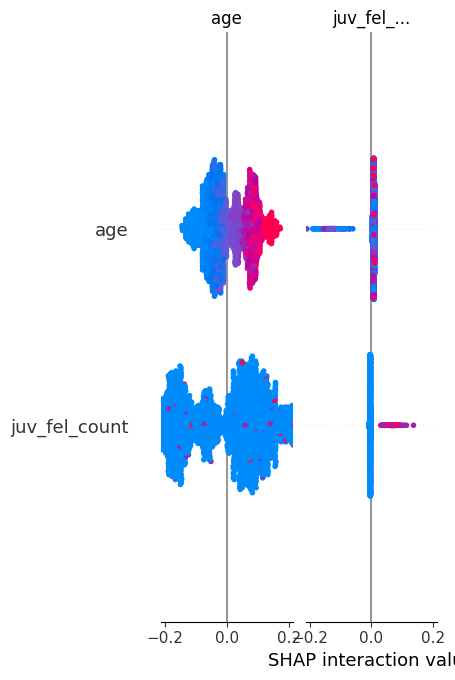

In [209]:
shap.summary_plot(shapValues, X_test_enc)

In [210]:
# shap.plots.beeswarm(shapValues, max_display=99, show = False)

# ANCHORS

In [211]:
# anchors